Note: Some of this references things I explored in "Playing with Periodograms" notebook.

# Following the recommendations of VanderPlas 2018: Understanding the Lomb-Scargle Periodogram

Link:
https://ui.adsabs.harvard.edu/abs/2018ApJS..236...16V/abstract

We are doing this because we trust Jake Vanderplas in his guide here: 
[Understanding the Lomb-Scargle Periodogram](https://iopscience.iop.org/article/10.3847/1538-4365/aab766#apjsaab766s8), especially the suggestions in Section 8, which I'll paste here:

-----
8.1. Summary of Recommendations

   1.  
    **Choose an appropriate frequency grid**:
   2.  
    **Compute the window transform using the Lomb–Scargle periodogram**
   3.  
    **Compute the periodogram for your data**. 
   4.  
    **Plot the periodogram** 
   5.  
    **If the window function shows strong aliasing, locate the expected multiple maxima** 
   6.  
    **If you have prior knowledge** of the shape of light curves you are trying to detect, **consider using more complex models**
   7.  
    **If you are building an automated pipeline** based on Lomb–Scargle for use in a survey, **consider injecting known signals** 



In [26]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle

plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings('ignore')

In [27]:
# load data
times = np.loadtxt("sample_k_dates.txt")
mags = np.loadtxt("sample_k_mags.txt")


## 1. Choose an appropriate frequency grid

1.  
    **Choose an appropriate frequency grid**: the minimum can be set to zero, the maximum set based on the precision of the time measurements (Section 4.1.2), and the grid spacing set based on the temporal baseline of the data (Section 7.1) so as not to sample too coarsely around peaks. If this grid size is computationally intractable, reduce the maximum frequency based on what kinds of signals you are looking for.
    
### My inputs:
    
* `f_min = 0`: as recommended

* `f_max = 24 day^-1` (i.e., shortest period is 1 hr), due to astrophysical prior on shortest rotation rate observed for young brown dwarfs (Vos et al. 2020)

* `N_eval = 2.4e5` (240,000 evaluations, which oversamples each 'peak' by about a factor 20, very similar to the recommendation in Section 7.1 of vanderPlas 2018)

In [72]:
f_min = 0
f_max = 24
N_eval = int(2.4e5)

# 2. Compute the window transform

2.  
    **Compute the window transform using the Lomb–Scargle periodogram**, by substituting $g_n = 1$ for each $t_n$ and making sure not to pre-center the data or use a floating-mean model (Section 7.3.1). Examine this window function for dominant features, such as daily or annual aliases (see Figure 13) or Nyquist-like limits (see Figure 15).


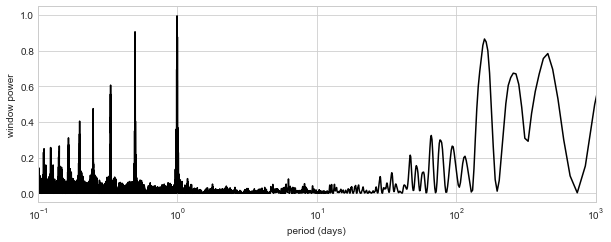

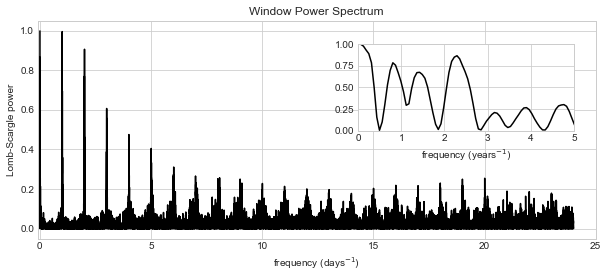

In [77]:
ls = LombScargle(times, 1, fit_mean=False, center_data=False)
freqW, powerW = ls.autopower(minimum_frequency=f_min, maximum_frequency=f_max)

fig, ax = plt.subplots(figsize=(10, 4))
fig.subplots_adjust(bottom=0.2)
ax.set_xscale('log')
ax.plot(1. / freqW, powerW, '-k', rasterized=True)

ax.set(xlabel='period (days)',
       ylabel='window power',
       xlim=(0.1, 1000));


fig, ax = plt.subplots(1, figsize=(10, 4), sharex=True, sharey=True)
ax.plot(freqW, powerW, '-k', rasterized=True)
ax.set(ylabel='Lomb-Scargle power',
       xlabel='frequency (days$^{-1}$)',
       xlim=(-0.1, 25),
       title='Window Power Spectrum')
inset = fig.add_axes([0.57, 0.5, 0.30, 0.3])
inset.plot(freqW * 365, powerW, '-k')
inset.set(xlabel='frequency (years$^{-1}$)',
             xlim=(0, 5), ylim=(0, 1))
inset.yaxis.set_major_locator(plt.MultipleLocator(0.25))

# 3.    Compute the periodogram for your data

   3.  
    **Compute the periodogram for your data**. You should always use the floating-mean model (Section 6.2), as it produces more robust periodograms and has few if any disadvantages. Avoid multiterm Fourier extensions (Section 6.3) when the signal has an unknown form, because its main effect is to increase periodogram noise (see  Figures 20–21).

Strongest frequency: 3.82 day^-1
Strongest period: 6.28 hours
[0.17134161 0.18552229 0.21651529]


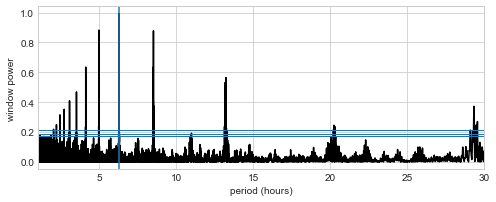

In [83]:
freq = np.linspace(0., 24., 24*10**4)

sin_mags = mags + np.sin(times*24)

ls = LombScargle(times, sin_mags)

# note: this lets the mean float by default
power = LombScargle(times, sin_mags).power(freq) 
# freq, power = ls.autopower(minimum_frequency=0, maximum_frequency=35)

fmax = freq[np.nanargmax(power)]
print(f"Strongest frequency: {fmax:.2f} day^-1")
print(f"Strongest period: {24. / fmax:.2f} hours")



# 4. Plot the periodogram.

   4.  
    **Plot the periodogram** and identify any patterns that may be caused by features you observed in the window function power. Plot reference lines showing several FAP levels to understand whether your periodogram peaks are significant enough to be labeled detections: use the Baluev method or the bootstrap method if it is computationally feasible (Section 7.4.2). Keep in mind exactly what the FAP measures and avoid the temptation to misinterpret it (Section 7.4.2.5).

FAP of peak: 8.249303007722374e-92


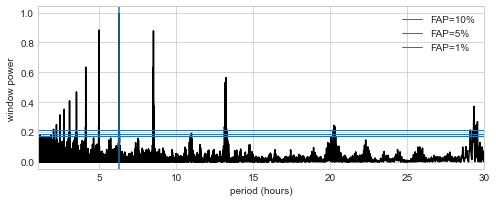

In [95]:
period_days = 1. / freq
period_hours = 24. / freq

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(period_hours, power, '-k', rasterized=True)
ax.axvline(24. / fmax)

ax.set(xlim=(1, 30),
       xlabel='period (hours)',
       ylabel='window power');

print(f"FAP of peak: {ls.false_alarm_probability(np.nanmax(power))}")

probabilities = [0.1, 0.05, 0.01]
levels = ls.false_alarm_level(probabilities)
# print(levels)
[ax.axhline(level, lw=1, label=f'FAP={int(100*prob)}%') for level, prob in zip(levels, probabilities)]
ax.legend()

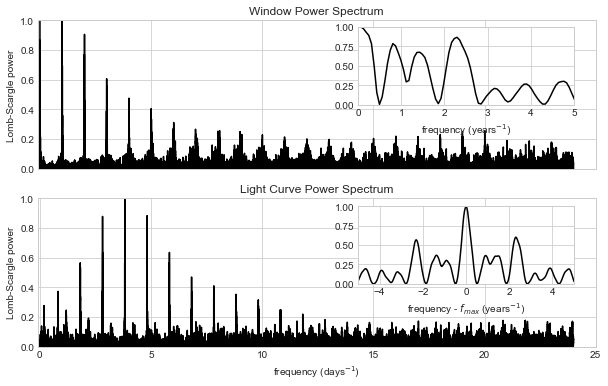

In [90]:
fig, ax = plt.subplots(2, figsize=(10, 6), sharex=True, sharey=True)
ax[0].plot(freqW, powerW, '-k', rasterized=True)

ax[1].plot(freq, power, '-k', rasterized=True)


ax[0].set(ylabel='Lomb-Scargle power',
          title='Window Power Spectrum')
ax[1].set(xlabel='frequency (days$^{-1}$)',
          ylabel='Lomb-Scargle power',
          title='Light Curve Power Spectrum',
          xlim=(-0.1, 25),
          ylim=(0, 1))

inset = [fig.add_axes([0.57, 0.685, 0.30, 0.18]),
         fig.add_axes([0.57, 0.27, 0.30, 0.18])]

inset[0].plot(freqW * 365, powerW, '-k')
inset[1].plot((freq - fmax) * 365, power, '-k')

inset[0].set(xlabel='frequency (years$^{-1}$)',
             xlim=(0, 5), ylim=(0, 1))
inset[0].yaxis.set_major_locator(plt.MultipleLocator(0.25))
inset[1].set(xlabel='frequency - $f_{max}$ (years$^{-1}$)',
             xlim=(-5, 5), ylim=(0, 1));
inset[1].yaxis.set_major_locator(plt.MultipleLocator(0.25))